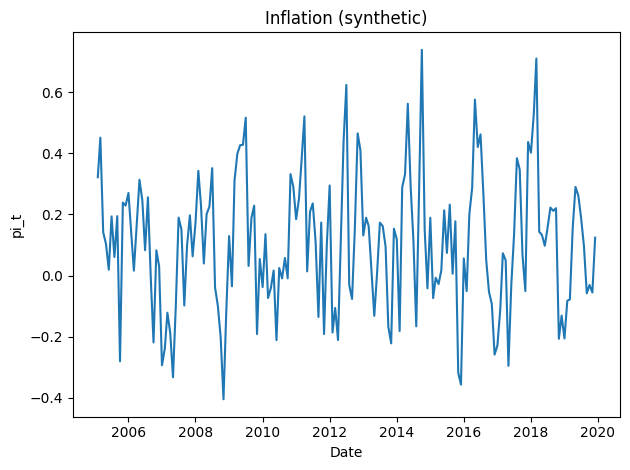

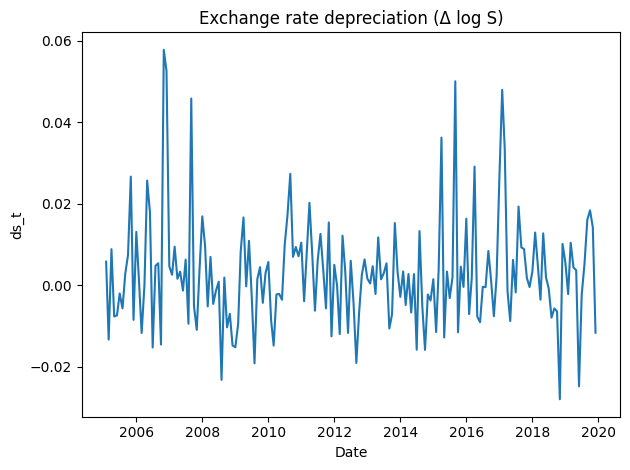

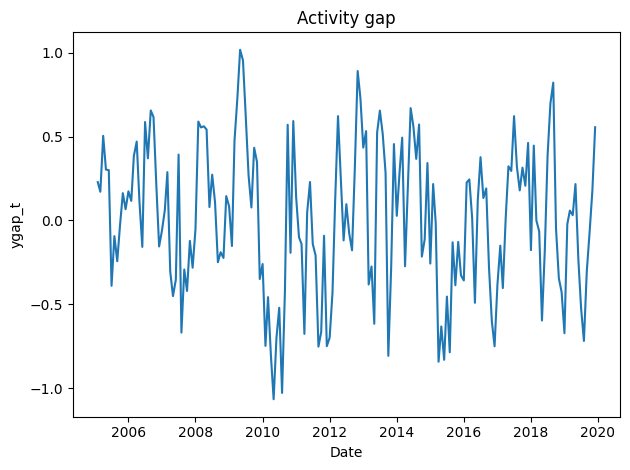

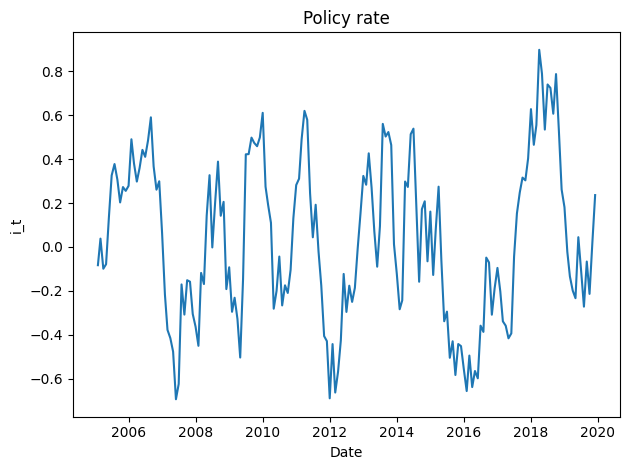


=== Linear ARX(1) benchmark (robust s.e.) ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     22.20
Date:                Fri, 26 Sep 2025   Prob (F-statistic):           8.05e-15
Time:                        00:44:59   Log-Likelihood:                 50.782
No. Observations:                 179   AIC:                            -91.56
Df Residuals:                     174   BIC:                            -75.63
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const

c:\Users\CESAR\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
C:\Users\CESAR\AppData\Local\Temp\ipykernel_18532\445070707.py:111: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F = float(w.fvalue)


Bootstrap p-value (wild, B=99): 0.950


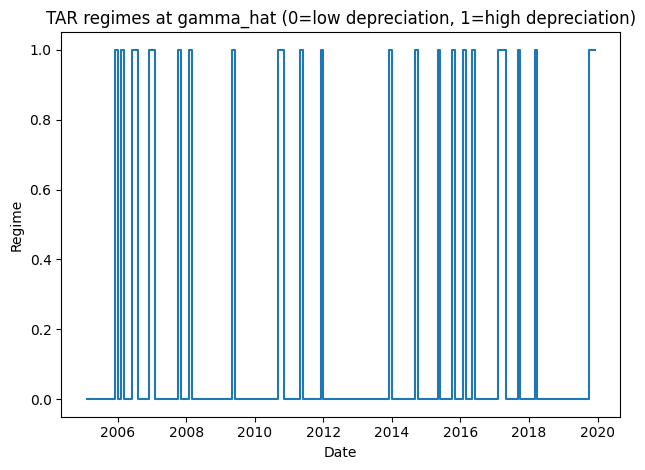


=== Interpretation (classroom notes) ===
- Estimated threshold gamma_hat ≈ 0.0128. Large depreciation regime fraction: 15.08%.
- Compare ds_l1 across regimes: larger in Regime 2 implies stronger FX pass-through when depreciation is high.
  Regime 1 ds_l1 = 0.152 (se 1.748)
  Regime 2 ds_l1 = -3.197 (se 2.363)
- Persistence (pi_l1): Reg1 = 0.398, Reg2 = 0.405.
- sup-Wald bootstrap p-value ≈ 0.950. If < 0.10, evidence of threshold nonlinearity.
- Always check residual diagnostics by regime and validate with out-of-sample forecasting.


In [1]:
# Re-run the full TAR demo (the previous cell got reset).

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

rng = np.random.default_rng(11)
T = 180
dates = pd.period_range('2005-01', periods=T, freq='M').to_timestamp()

# Shocks
eps_pi = rng.normal(0, 0.2, T)
eps_ds = rng.normal(0, 0.01, T)
eps_y  = rng.normal(0, 0.4, T)
eps_i  = rng.normal(0, 0.15, T)

# Activity gap
ygap = np.zeros(T)
for t in range(1, T):
    ygap[t] = 0.7*ygap[t-1] + eps_y[t]

# Policy rate
i_rate = np.zeros(T)
for t in range(1, T):
    i_rate[t] = 0.85*i_rate[t-1] + 0.2*ygap[t-1] + 0.15*eps_pi[t-1] + eps_i[t]

# Exchange rate depreciation with occasional jumps
ds = eps_ds.copy()
shock_idx = rng.choice(np.arange(2, T), size=10, replace=False)
ds[shock_idx] += rng.normal(0.04, 0.015, size=shock_idx.size)

# True TAR for inflation
gamma_true = 0.02
pi = np.zeros(T)
mu1, phi1, b1 = 0.05, 0.40, 0.15
mu2, phi2, b2 = 0.08, 0.65, 0.40
c, d = 0.10, -0.05
for t in range(1, T):
    reg2 = ds[t-1] > gamma_true
    mu  = mu2 if reg2 else mu1
    phi = phi2 if reg2 else phi1
    b   = b2  if reg2 else b1
    pi[t] = mu + phi*pi[t-1] + b*ds[t-1] + c*ygap[t-1] + d*i_rate[t-1] + eps_pi[t]

df = pd.DataFrame({'pi':pi,'ds':ds,'ygap':ygap,'i':i_rate}, index=dates)
df['pi_l1'] = df['pi'].shift(1)
df['ds_l1'] = df['ds'].shift(1)
df['ygap_l1'] = df['ygap'].shift(1)
df['i_l1'] = df['i'].shift(1)
df = df.dropna().copy()

# Plots
plt.figure(); plt.plot(df.index, df['pi']); plt.title('Inflation (synthetic)'); plt.xlabel('Date'); plt.ylabel('pi_t'); plt.tight_layout(); plt.show()
plt.figure(); plt.plot(df.index, df['ds']); plt.title('Exchange rate depreciation (Δ log S)'); plt.xlabel('Date'); plt.ylabel('ds_t'); plt.tight_layout(); plt.show()
plt.figure(); plt.plot(df.index, df['ygap']); plt.title('Activity gap'); plt.xlabel('Date'); plt.ylabel('ygap_t'); plt.tight_layout(); plt.show()
plt.figure(); plt.plot(df.index, df['i']); plt.title('Policy rate'); plt.xlabel('Date'); plt.ylabel('i_t'); plt.tight_layout(); plt.show()

# Linear ARX(1)
Y = df['pi'].values
X_lin = sm.add_constant(df[['pi_l1','ds_l1','ygap_l1','i_l1']].values)
lin_model = sm.OLS(Y, X_lin).fit(cov_type='HC1')
print("\n=== Linear ARX(1) benchmark (robust s.e.) ===")
print(lin_model.summary())

# TAR grid search
Q = df['ds_l1'].values
grid = np.quantile(Q, np.linspace(0.15, 0.85, 41))

def fit_tar_at_gamma(gamma, y, X, Q):
    I1 = Q <= gamma
    I2 = Q > gamma
    if I1.mean() < 0.10 or I2.mean() < 0.10:
        return np.inf, None, None, I1, I2
    res1 = sm.OLS(y[I1], X[I1]).fit(cov_type='HC1')
    res2 = sm.OLS(y[I2], X[I2]).fit(cov_type='HC1')
    ssr = np.sum(res1.resid**2) + np.sum(res2.resid**2)
    return ssr, res1, res2, I1, I2

ssr_list, fits = [], []
for g in grid:
    ssr, r1, r2, I1, I2 = fit_tar_at_gamma(g, Y, X_lin, Q)
    ssr_list.append(ssr)
    fits.append((r1, r2, I1, I2))

best_idx = int(np.nanargmin(ssr_list))
gamma_hat = grid[best_idx]
res1_hat, res2_hat, I1_hat, I2_hat = fits[best_idx]

print("\n=== TAR grid-search results ===")
print(f"Grid size: {len(grid)} | gamma_hat = {gamma_hat:.4f}")
print(f"Regime sizes: Reg1 (Q<=gamma): {I1_hat.sum()} obs, Reg2 (Q>gamma): {I2_hat.sum()} obs")
print(f"SSR(linear) = {np.sum(lin_model.resid**2):.4f} | SSR(TAR@gamma_hat) = {np.min(ssr_list):.4f}")

print("\n--- Regime 1 (Q <= gamma_hat) coefficients (robust s.e.) ---")
print(pd.DataFrame({'coef': res1_hat.params, 'se(HC1)': res1_hat.bse}, index=['const','pi_l1','ds_l1','ygap_l1','i_l1']))

print("\n--- Regime 2 (Q > gamma_hat) coefficients (robust s.e.) ---")
print(pd.DataFrame({'coef': res2_hat.params, 'se(HC1)': res2_hat.bse}, index=['const','pi_l1','ds_l1','ygap_l1','i_l1']))

# sup-Wald per gamma (pedagogical)
def wald_for_gamma(gamma, y, X, Q):
    I1 = (Q <= gamma).astype(float)
    I2 = 1.0 - I1
    Xs = np.column_stack([X * I1[:,None], X * I2[:,None]])
    res = sm.OLS(y, Xs).fit()
    k = X.shape[1]
    R = np.hstack([np.eye(k), -np.eye(k)])
    r = np.zeros(k)
    w = res.wald_test((R, r), use_f=True)
    F = float(w.fvalue)
    W = F * k
    return W

wald_vals, valid_mask = [], []
for g in grid:
    I1 = Q <= g; I2 = Q > g
    ok = (I1.mean() >= 0.10) and (I2.mean() >= 0.10)
    valid_mask.append(ok)
    if ok:
        w = wald_for_gamma(g, Y, X_lin, Q)
    else:
        w = np.nan
    wald_vals.append(w)

wald_arr = np.array(wald_vals)
sup_wald = np.nanmax(wald_arr)
g_sup = grid[np.nanargmax(wald_arr)]
print("\n=== sup-Wald (pedagógico) for threshold ===")
print(f"sup-Wald = {sup_wald:.3f} at gamma = {g_sup:.4f} (nonstandard; next: bootstrap p-value)")

# Wild bootstrap under H0(linear)
B = 99
lin_fit = lin_model.fittedvalues
resid = lin_model.resid
sup_wald_star = np.zeros(B)

for b in range(B):
    eta = np.where(rng.random(len(resid)) < 0.5, -1.0, 1.0)  # Rademacher
    y_star = lin_fit + resid * eta
    wstars = []
    for g, ok in zip(grid, valid_mask):
        if not ok:
            wstars.append(np.nan); continue
        wstars.append(wald_for_gamma(g, y_star, X_lin, Q))
    sup_wald_star[b] = np.nanmax(wstars)

pval = (np.sum(sup_wald_star >= sup_wald) + 1) / (B + 1)
print(f"Bootstrap p-value (wild, B={B}): {pval:.3f}")

# Regime classification
regime_indicator = (Q > gamma_hat).astype(int)
plt.figure()
plt.step(df.index, regime_indicator, where='post')
plt.title('TAR regimes at gamma_hat (0=low depreciation, 1=high depreciation)')
plt.xlabel('Date'); plt.ylabel('Regime')
plt.tight_layout()
plt.show()

# Interpretations
print("\n=== Interpretation (classroom notes) ===")
print(f"- Estimated threshold gamma_hat ≈ {gamma_hat:.4f}. Large depreciation regime fraction: {regime_indicator.mean():.2%}.")
print("- Compare ds_l1 across regimes: larger in Regime 2 implies stronger FX pass-through when depreciation is high.")
print(f"  Regime 1 ds_l1 = {res1_hat.params[2]:.3f} (se {res1_hat.bse[2]:.3f})")
print(f"  Regime 2 ds_l1 = {res2_hat.params[2]:.3f} (se {res2_hat.bse[2]:.3f})")
print(f"- Persistence (pi_l1): Reg1 = {res1_hat.params[1]:.3f}, Reg2 = {res2_hat.params[1]:.3f}.")
print(f"- sup-Wald bootstrap p-value ≈ {pval:.3f}. If < 0.10, evidence of threshold nonlinearity.")
print("- Always check residual diagnostics by regime and validate with out-of-sample forecasting.")
